In [1]:
import math
import numpy as np
import numpy.random as npr
from numpy import linalg
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset
import torch.optim as optim
import time
from math import *
torch.cuda.set_device(1)

In [2]:
torch.set_default_tensor_type('torch.DoubleTensor')

In [3]:
class ResNet(nn.Module):
    def __init__(self,dim, m,o):
        super(ResNet, self).__init__()
        self.Ix = torch.zeros([dim,m]).cuda()
        for i in range(dim):
            self.Ix[i,i] = 1
        self.fc1 = nn.Linear(dim, m)
        self.fc2 = nn.Linear(m, m)
        
        self.fc3 = nn.Linear(m, m)
        self.fc4 = nn.Linear(m, m)
 
        
        self.outlayer = nn.Linear(m, o)

    def forward(self, x):
        s = x@self.Ix
        y = self.fc1(x)
        y = F.relu(y)**deg
        y = self.fc2(y)
        y = F.relu(y)**deg
        y = y+s
        
        s=y
        y = self.fc3(y)
        y = F.relu(y)**deg
        y = self.fc4(y)
        y = F.relu(y)**deg
        y = y+s

        
        output = self.outlayer(y)
        return output
deg = 3

In [4]:
def sol_exact(x):
    sol = (x[:,0]**2*torch.sin(pi*x[:,1])*torch.sin(pi*x[:,2])).reshape(x.size()[0],1)
    return sol

In [5]:
def sol_exact_H1(x):
    sol = torch.zeros(x.size()[0],4).cuda()
    sol[:,0] = sol_exact(x).reshape(1,x.size()[0])
    sol[:,1] = (2*x[:,0]*torch.sin(pi*x[:,1])*torch.sin(pi*x[:,2]))
    sol[:,2] = (pi*x[:,0]**2*torch.cos(pi*x[:,1])*torch.sin(pi*x[:,2]))
    sol[:,3] = (pi*x[:,0]**2*torch.sin(pi*x[:,1])*torch.cos(pi*x[:,2]))
    return sol

In [6]:
def source(x):
    sol = (2*torch.sin(pi*x[:,1])*torch.sin(pi*x[:,2])).reshape(x.size()[0],1)
    sol =  sol +  (2*pi**2*x[:,0]**2*torch.sin(pi*x[:,1])*torch.sin(pi*x[:,2])).reshape(x.size()[0],1)    
    return sol

In [7]:
Batch_size = 50000
def MIM():
    x = torch.rand(Batch_size,3).cuda()
    x.requires_grad = True
    u = model_u(x)
    v = model_v(x)
    p = model_p(x)
    ve = torch.ones(u.shape).cuda()
    Du = torch.autograd.grad(u,x,grad_outputs=ve,create_graph=True)[0]
    Np = Du[:,1:3].reshape(x.size()[0],2)
    Dv = torch.autograd.grad(v,x,grad_outputs=ve,create_graph=True)[0]
    v_t = Dv[:,0].reshape(x.size()[0],1)
    uxx = torch.zeros(x.size()[0],1).cuda()
    for i in range(2):
        uxi = p[:,i].reshape(x.size()[0],1)
        uxxi = torch.autograd.grad(uxi,x,grad_outputs=ve,create_graph=True)[0]
        uxx = uxx + uxxi[:,i+1].reshape(x.size()[0],1)
    loss =  torch.sum( (Np-p)**2 )/50000 + torch.sum( (v_t - uxx - source(x))**2 )/50000
    return loss

In [8]:
def BC():
    x1 = torch.rand(1000,3).cuda()
    x1[:,0] = 0
    loss = torch.sum(model_v(x1)**2)/1000
    return loss

In [9]:
model_u1 = ResNet(3,20,1)
model_p1 = ResNet(3,20,2)
device=torch.device("cuda:1" )

model_u1.to(device)
model_p1.to(device)

ResNet(
  (fc1): Linear(in_features=3, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=20, bias=True)
  (outlayer): Linear(in_features=20, out_features=2, bias=True)
)

In [10]:
def model_u(x):
    return x[:,0:1]*(x*(1-x))[:,1:2]*(x*(1-x))[:,2:3]*model_u1(x)
def model_v(x):
    x.requires_grad = True
    u = model_u(x)
    ve = torch.ones(u.shape).cuda()
    Du = torch.autograd.grad(u,x,grad_outputs=ve,create_graph=True)[0]
    v = Du[:,0].reshape(x.size()[0],1)
    return v
def model_p(x):
    return model_p1(x)

In [11]:
def initparam(model,sigma):
    for m in model.modules():
        if isinstance(m,nn.Linear):
            m.weight.data.uniform_(-sigma,sigma)#全连接层参数初始化
            m.bias.data.uniform_(0,sigma)
    return model
  

In [12]:
notes = torch.rand(10000,3).cuda()
notes[:,0] = 1
exact = sol_exact_H1(notes)
u_L2 = sqrt(torch.sum((exact[:,0])**2)/10000)
v_L2 = sqrt(torch.sum(exact[:,1]**2)/10000)
p_L2 = sqrt(torch.sum((exact[:,2:4])**2)/10000)
def loss_error():
    notes = torch.rand(10000,3).cuda()
    notes[:,0] = 1
    predict = torch.zeros(10000,4).cuda()
    predict[:,0] = model_u(notes).reshape([1,notes.size()[0]])
    predict[:,1] = model_v(notes).reshape([1,notes.size()[0]])
    predict[:,2:4] = model_p(notes)
    exact = sol_exact_H1(notes)
    value1 = sqrt(torch.sum((exact[:,0] - predict[:,0])**2)/10000)/u_L2
    value2 = sqrt(torch.sum((exact[:,1] - predict[:,1])**2)/10000)/v_L2
    value3 =  sqrt(torch.sum((exact[:,2:4] - predict[:,2:4])**2)/10000)/p_L2
    return value1,value2,value3

In [13]:
traintime = 50000
error_save=np.zeros([3,traintime])
optimizer = optim.Adam([
                {'params': model_u1.parameters()},
                {'params': model_p1.parameters()}
            ])
time_start=time.time()
for i in range(traintime):
    optimizer.zero_grad()
    losses = MIM()+BC()
    losses.backward()
    optimizer.step() 
    error1,error2,error3=loss_error()
    error_save[0,i]=float(error1)
    error_save[1,i]=float(error2)
    error_save[2,i]=float(error3)
    if i%500==1:
        print("i= ",i)
        print("error =",error1)
        print("loss =",losses.detach())
        np.save("error_save_LDG_wave_2D_q_w20_v1.npy", error_save)
np.save("error_save_LDG_wave_2D_q_w20_v1.npy", error_save)
time_end=time.time()
print('time cost',time_end-time_start,'s')

i=  1
error = 0.9962311077096166
loss = tensor(28.9357, device='cuda:1')
i=  501
error = 0.051232442281193565
loss = tensor(0.1801, device='cuda:1')
i=  1001
error = 0.034881679918129356
loss = tensor(0.0522, device='cuda:1')
i=  1501
error = 0.0320594658989221
loss = tensor(0.0232, device='cuda:1')
i=  2001
error = 0.028382020392995665
loss = tensor(0.0136, device='cuda:1')
i=  2501
error = 0.02460738037361043
loss = tensor(0.0099, device='cuda:1')
i=  3001
error = 0.0224093827857428
loss = tensor(0.0064, device='cuda:1')
i=  3501
error = 0.019920928969086257
loss = tensor(0.0048, device='cuda:1')
i=  4001
error = 0.01824402646725129
loss = tensor(0.0043, device='cuda:1')
i=  4501
error = 0.01637650176401558
loss = tensor(0.0034, device='cuda:1')
i=  5001
error = 0.015595618046311481
loss = tensor(0.0028, device='cuda:1')
i=  5501
error = 0.014698836960582764
loss = tensor(0.0026, device='cuda:1')
i=  6001
error = 0.01314076094209065
loss = tensor(0.0021, device='cuda:1')
i=  6501
err

In [14]:
import matplotlib.pyplot as plt
error = np.load("error_save_LDG_wave_2D_q_w20.npy")

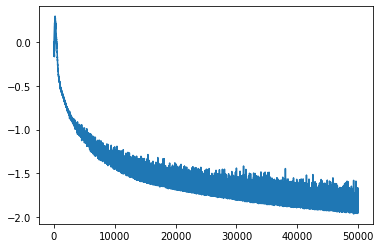

In [15]:
plt.plot(np.log10(error[1]))

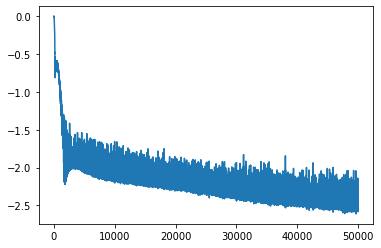

In [16]:
plt.plot(np.log10(error[0]))

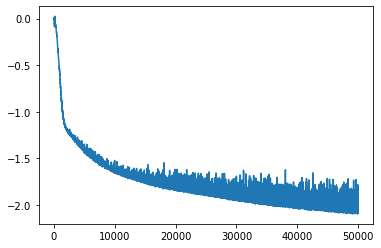

In [17]:
plt.plot(np.log10(error[2]))